In [9]:
import os,sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

plt.rcParams["grid.linestyle"]="dashed"
plt.rcParams["figure.edgecolor"] = "black"


#some plotting routines
import plotting

# data processing
import data_higgs as dh

#import the working methods
import tensorflow as tf
print("TensorFlow version ",tf.__version__)

from tensorflow import keras


from tensorflow.keras import Sequential,Model
from tensorflow.keras.layers import Dense, Lambda
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

TensorFlow version  2.17.0


In [10]:
#--------- globals

# Need to see a large portion of the data before we can build a layer, for
# example half of data n_batches_per_layer =  NBATCH_FRAC * NUM_EXAMPLES / BATCH_SIZE
BATCH_SIZE = 1000

# Seed value
# Apparently you may use different seed values at each stage
SEED_VALUE= 10001
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(SEED_VALUE)
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(SEED_VALUE)
# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(SEED_VALUE)
# 4. Set `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(SEED_VALUE)

In [11]:
#-------- routines

def split_xy(rawdata):
    #split features and labels from data
    #prepare the data => normalizations !

    # split
    data_y=rawdata['hlabel'] # labels only: 0.=bkg, 1.=sig
    data_x=rawdata.drop(['hlabel'], axis=1) # features only

    #now prepare the data
    mu = data_x.mean()
    s = data_x.std()
    dmax = data_x.max()
    dmin = data_x.min()

    # normal/standard rescaling
    #data_x = (data_x - mu)/s

    # scaling to [-1,1] range
    #data_x = -1. + 2.*(data_x - dmin)/(dmax-dmin)

    # scaling to [0,1] range
    data_x = (data_x - dmin)/(dmax-dmin)


    return data_x,data_y

In [12]:
def main(nepoch=10):
      # Training progress and eval results are shown as logging.INFO; so enables it.

    #needs to be done once if the h5 files need to be recreated...
    #dh.download_and_make_data()

    hdata=dh.load_data('./data')
    data_fnames=hdata['feature_names'].to_numpy()[1:] #drop labels
    n_dims=data_fnames.shape[0]
    print ("Entries read {} with feature names {}".format(n_dims,data_fnames))

    x_trn,y_trn=split_xy(hdata['train']) # training sample, should split a fraction for testing
    x_train, x_test,y_train, y_test = train_test_split(x_trn,y_trn,test_size=0.1) # 10% split
    x_val,y_val=split_xy(hdata['valid']) # independent cross-valid sample

    #print("Shapes train:{} and test:{}".format(x_train.shape,x_test.shape))

    #plot distributions
    #plotting.plot_sig_bkg_from_np_arrays(x_train.to_numpy(),y_train.to_numpy(),data_fnames,logy=False)

    # ready the data for TF
    ds_train = tf.data.Dataset.from_tensor_slices((x_train.to_numpy(),y_train.to_numpy()))
    ds_train = ds_train.repeat()
    ds_train = ds_train.batch(BATCH_SIZE,drop_remainder=True)

    ds_test = tf.data.Dataset.from_tensor_slices((x_test.to_numpy(),y_test.to_numpy()))
    ds_test = ds_test.repeat()
    ds_test = ds_test.batch(BATCH_SIZE,drop_remainder=True)

    train_steps=int(x_train.shape[0]/BATCH_SIZE)
    test_steps=int(x_test.shape[0]/BATCH_SIZE)
    print("Steps train:{} and test:{}".format(train_steps,test_steps))

    # build a model - a DNN in TF 2.0
    dnn = Sequential()
    for i in range(2):
          dnn.add(Dense(50, input_dim=n_dims, activation='relu'))
    dnn.add(Dense(1, activation='sigmoid')) # output layer/value
    dnn.add(Lambda(lambda x: tf.squeeze(x, axis=-1)))  # Converts (None, 1) to (None,))
    #plot_model(dnn, to_file='dnn_model.png', show_shapes=True)

    dnn.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='binary_crossentropy',
                metrics=['accuracy', 'AUC', 'binary_crossentropy'])

    dnn.summary()

    #optional early stopping
    eval_metric = 'AUC'
    earlystop_callback = EarlyStopping(
            mode='max',
            monitor='val_' + eval_metric,
            patience=5,
            min_delta=0.00001,
            verbose=1
        )

    #run the training
    dnn_model_history = dnn.fit(ds_train,
            epochs=nepoch,
            steps_per_epoch=train_steps,
            #callbacks=[earlystop_callback],
            validation_data=ds_test,
            validation_steps=test_steps
        )

    #plot training history
    print("history values",dnn_model_history.history.keys())
    plotting.plot_history([('DNN model', dnn_model_history),],key='binary_crossentropy')
    plotting.plot_history([('DNN model', dnn_model_history),],key='AUC')
    plotting.plot_history([('DNN model', dnn_model_history),],key='accuracy')

    #plot & print results like ROC and score distribution etc...
    y_score=dnn.predict(x_val.to_numpy())
    plotting.plot_roc(y_val,y_score)
    plotting.plot_score(y_val,y_score)
    print()
    auc=roc_auc_score(y_val,y_score)
    print("AUC score: {}".format(auc))


Entries read 18 with feature names ['lepton-pT' 'lepton-eta' 'missing-energy' 'jet_1-pt' 'jet_1-eta'
 'jet_2-pt' 'jet_2-eta' 'jet_3-pt' 'jet_3-eta' 'jet_4-pt' 'jet_4-eta'
 'm_jj' 'm_jjj' 'm_lv' 'm_jlv' 'm_bb' 'm_wbb' 'm_wwbb']
Steps train:360 and test:40


/Users/luka/.pyenv/versions/3.11.2/envs/phys/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 50)             │           950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            51 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_3 (Lambda)               │ (None)                 │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,551 (13.87 KB)

 Trainable params: 3,551 (13.87 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - AUC: 0.5021 - accuracy: 0.1414 - binary_crossentropy: 0.6925 - loss: 0.6925 - val_AUC: 0.5000 - val_accuracy: 0.3250 - val_binary_crossentropy: 0.6913 - val_loss: 0.6913
Epoch 2/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - AUC: 0.4998 - accuracy: 0.3484 - binary_crossentropy: 0.6915 - loss: 0.6915 - val_AUC: 0.5000 - val_accuracy: 0.5000 - val_binary_crossentropy: 0.6913 - val_loss: 0.6913
Epoch 3/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - AUC: 0.4998 - accuracy: 0.3956 - binary_crossentropy: 0.6915 - loss: 0.6915 - val_AUC: 0.4999 - val_accuracy: 0.5250 - val_binary_crossentropy: 0.6913 - val_loss: 0.6913
Epoch 4/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - AUC: 0.5001 - accuracy: 0.5124 - binary_crossentropy: 0.6915 - loss: 0.6915 - val_AUC: 0.5000 - val_accuracy: 0.5250 - val_binary_crossentropy: 0.6913 - val_loss: 0.6913
Epoch 5/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - AUC: 0.4996 - accuracy: 0.5116 - binary_cross

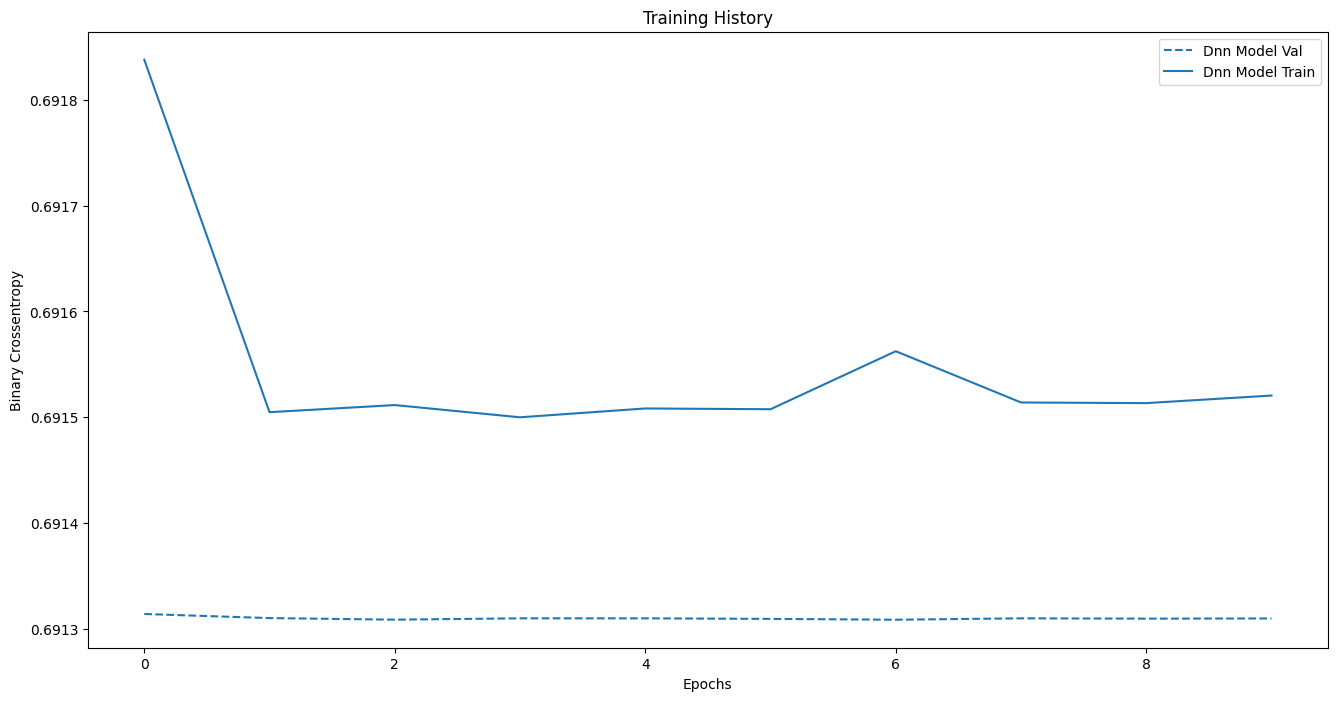

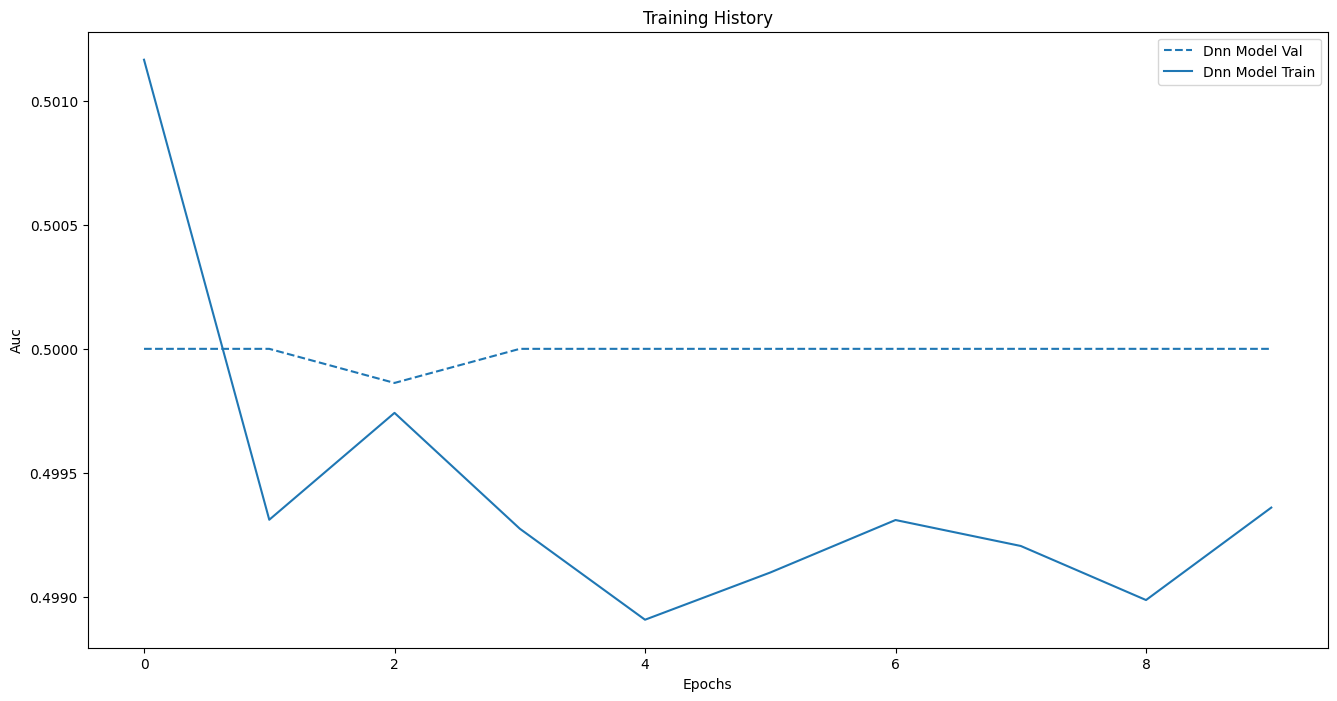

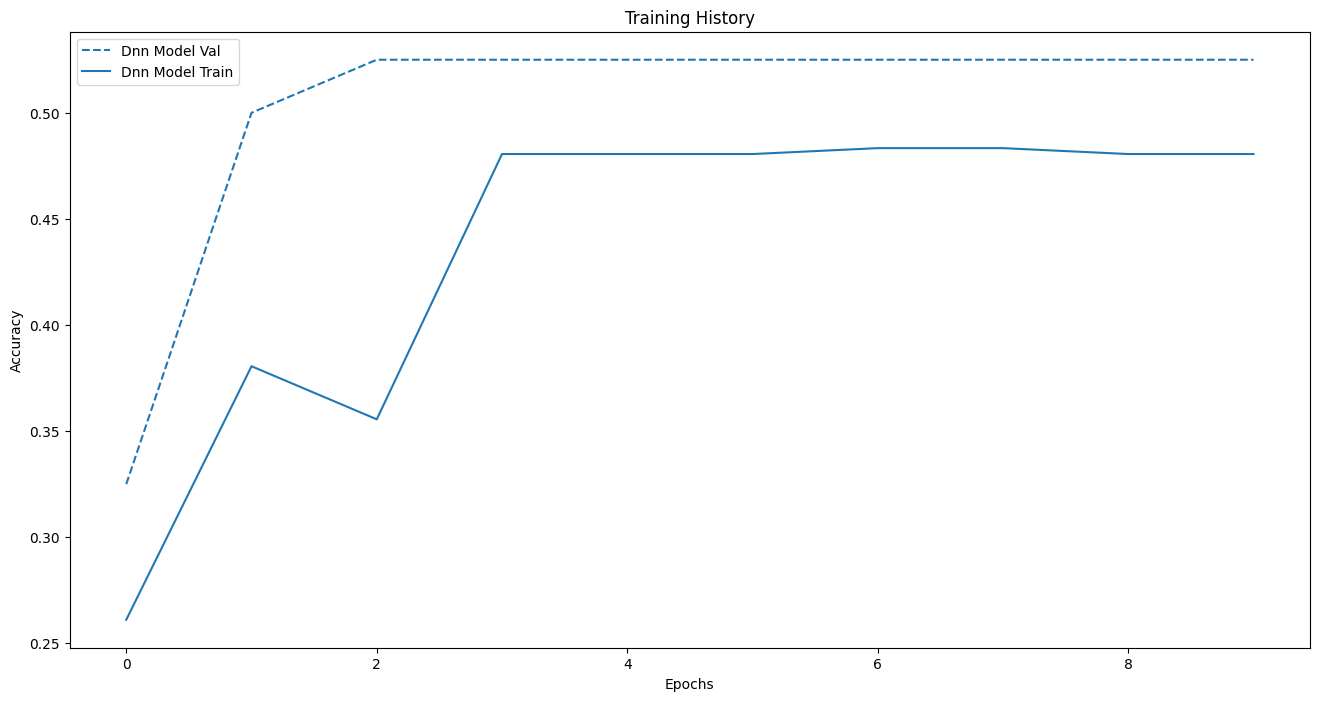

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step

AUC score: 0.5


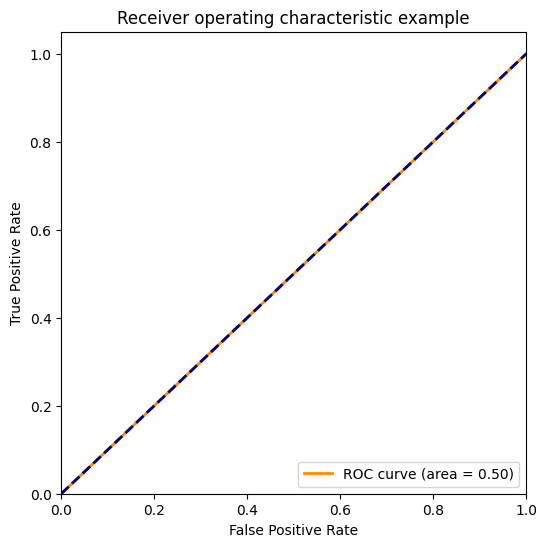

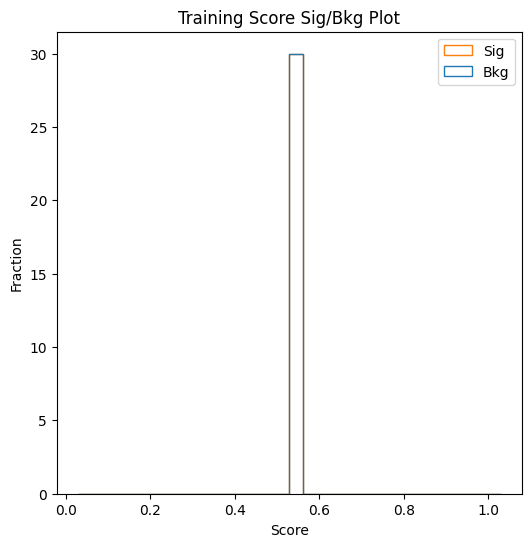

In [14]:
main(10)